# G-NetTrack Pro

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intrig-unicamp/hackathon5G/blob/main/datasets/g-nettrack-pro.ipynb)

[Manual do G-NetTrack](https://gyokovsolutions.com/manual-g-nettrack/#:~:text=Here%20is%20description%20of%20logfile%20columns)

Esse Notebook contém uma breve análise dos dados que o G-NetTrack Pro dispõe. Os participantes são encorajados a experimentar com os dados para descobrir padrões, formas de resolver problemas no contexto da Hackathon.

O G-NetTrack Pro é um aplicativo móvel para dispositivos Android que permite aos usuários realizar testes e análises detalhadas da rede celular em tempo real. Com ele, é possível medir a intensidade do sinal, a qualidade da conexão, a latência e outras métricas importantes para avaliar o desempenho da rede. O aplicativo também oferece recursos avançados, como mapeamento de cobertura e análise de interferência de sinal. Com o G-NetTrack Pro, os usuários podem obter informações valiosas sobre a rede celular em sua área e identificar possíveis problemas de conectividade.

Os dados utilizados nesse Notebook foram extraídos a partir de coletas usando o G-NetTrack Pro.

<center>
<img src='https://github.com/intrig-unicamp/hackathon5G/blob/main/assets/paulista-traces.png?raw=true' /><br />
<i>Parte do trajeto realizado durante a coleta de traces</i>
</center>

## Instalação das dependências

Instalar as dependências no ambiente adequado (pip ou Anaconda).

In [1]:
try:
    import google.colab as _
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install pandas numpy seaborn -q
else:
    !conda install pandas numpy seaborn -qy --freeze-installed

## Obtendo arquivos de dados

Baixamos os arquivos caso o Notebook esteja sendo executado no ambiente do Google Colab. A variável de prefixo do caminho dos arquivos é definida de acordo.

In [2]:
if IN_COLAB:
    !git clone --depth=1 https://github.com/intrig-unicamp/hackathon5G.git hackathon5G

DATA_PATH_PREFIX = './hackathon5G/datasets' if IN_COLAB else '.'

## Importando dependências globais

In [3]:
from IPython.display import display, Markdown
import pandas as pd
import numpy as np
import seaborn as sns

import os

pd.set_option('display.max_columns', None)

## Carregando os dados

In [4]:
GNETTRACKPRO_PATH = f'{DATA_PATH_PREFIX}/g-nettrack-pro'

datasets = [ file for file in os.listdir(GNETTRACKPRO_PATH) if file.endswith('.txt') ]

gnetDf = pd.concat([ pd.read_csv(f'{GNETTRACKPRO_PATH}/{dataset}', sep='\t', low_memory=False, on_bad_lines='warn') for dataset in datasets ]).copy()

Skipping line 1291: expected 260 fields, saw 390
Skipping line 1292: expected 260 fields, saw 390
Skipping line 1293: expected 260 fields, saw 390
Skipping line 1294: expected 260 fields, saw 390
Skipping line 1295: expected 260 fields, saw 390
Skipping line 1296: expected 260 fields, saw 390
Skipping line 1297: expected 260 fields, saw 390
Skipping line 1298: expected 260 fields, saw 390
Skipping line 1299: expected 260 fields, saw 390
Skipping line 1300: expected 260 fields, saw 390
Skipping line 1301: expected 260 fields, saw 390
Skipping line 1302: expected 260 fields, saw 390
Skipping line 1303: expected 260 fields, saw 390
Skipping line 1304: expected 260 fields, saw 390
Skipping line 1305: expected 260 fields, saw 390
Skipping line 1306: expected 260 fields, saw 390
Skipping line 1307: expected 260 fields, saw 390
Skipping line 1308: expected 260 fields, saw 390
Skipping line 1309: expected 260 fields, saw 390
Skipping line 1310: expected 260 fields, saw 390
Skipping line 1311: 

## Normalização dos valores

Removemos entradas cujo valor é igual ao nome da coluna (isso acontece quando a sessão de medição no G-NetTrack é reiniciada, o que causa a reescrita do cabeçalho CSV)

In [5]:
gnetDf.drop(gnetDf.loc[gnetDf.Timestamp == 'Timestamp'].index, inplace=True)

Transformamos o campo `Timestamp` para o tipo `datetime` e criamos outro campo `Timestamp_seconds` para armazenar o tempo em _unix epoch_

In [6]:
gnetDf.Timestamp = pd.to_datetime(gnetDf.Timestamp, format='%Y.%m.%d_%H.%M.%S')
gnetDf['Timestamp_seconds'] = gnetDf.Timestamp.astype(int) // 10**9

Reordenamos o conjunto de dados com base no tempo

In [7]:
gnetDf.sort_values('Timestamp', inplace=True, ignore_index=True)

Preenchemos com `NaN` células que possuem valores inválidos (primeira passagem)

In [8]:
gnetDf.replace({
    'Altitude': { '--': np.nan },
    'CHARGING': { 'true': True, 'false': False },
    **{ k: { '--': np.nan } for k in ['Longitude', 'Latitude', 'NetworkTech', 'Accuracy'] },
    **{ k: { '-': np.nan } for k in ['CQI', 'SNR', 'Qual', 'LTERSSI'] },
}, inplace=True)

Ajustamos o tipo das colunas

In [9]:
gnetDf = gnetDf.astype({
    **{ k: 'string' for k in ['NetworkTech', 'NetworkMode', 'Location', 'State', 'EVENT', 'CGI', 'Node', 'CellID', 'LAC', 'Operatorname', 'Operator', 'IP'] },
    **{ k: np.float64 for k in ['Longitude', 'Latitude', 'Speed', 'Accuracy', 'SNR', 'Level', 'Qual', 'CQI', 'LTERSSI', 'ARFCN', 'DL_bitrate', 'UL_bitrate', 'PSC', 'Altitude', 'Height'] },
    **{ k: np.int32 for k in ['BATTERY'] },
})

Preenchemos com `NaN` células que possuem valores inválidos (segunda passagem)

In [10]:
gnetDf.replace({
    'Altitude': { 0: np.nan },
    'Height': { 0: np.nan, -10000: np.nan },
    'Speed': { -99: np.nan },
}, inplace=True)

O Dataframe resultante é o seguinte:

In [11]:
gnetDf

Timestamp  Longitude   Latitude  Speed Operatorname Operator   
0     2023-01-21 14:44:46        NaN        NaN    NaN     CLARO_BR    72405  \
1     2023-01-21 14:44:46        NaN        NaN    NaN     CLARO_BR    72405   
2     2023-01-21 14:44:47        NaN        NaN    NaN     CLARO_BR    72405   
3     2023-01-21 14:44:48        NaN        NaN    NaN     CLARO_BR    72405   
4     2023-01-21 14:44:49        NaN        NaN    NaN     CLARO_BR    72405   
...                   ...        ...        ...    ...          ...      ...   
18341 2023-01-22 22:31:02 -46.728399 -23.595755    0.0     CLARO_BR    72405   
18342 2023-01-22 22:31:03 -46.728399 -23.595755    0.0     CLARO_BR    72405   
18343 2023-01-22 22:31:04 -46.728399 -23.595755    0.0     CLARO_BR    72405   
18344 2023-01-22 22:31:05 -46.728399 -23.595755    0.0     CLARO_BR    72405   
18345 2023-01-22 22:31:05 -46.728399 -23.595755    0.0     CLARO_BR    72405   

                   CGI Cellname    Node CellID    LAC NetworkTech NetworkMode   
0      724056481100018      NaN  113726     18  64811          4G         LTE  \
1      724056481100018      NaN  113726     18  64811          4G         LTE   
2      724056481100018      NaN  113726     18  64811          4G         LTE   
3      724056481100017      NaN  113726     17  64811          4G         LTE   
4      724056481100017      NaN  113726     17  64811          4G         LTE   
...                ...      ...     ...    ...    ...         ...         ...   
18341  724054571100003      NaN  111825      3  45711          4G         LTE   
18342  724054571100003      NaN  111825      3  45711          4G         LTE   
18343  724054571100003      NaN  111825      3  45711          4G         LTE   
18344  724054571100003      NaN  111825      3  45711          4G         LTE   
18345  724054571100003      NaN  111825      3  45711          4G         LTE   

       Level  Qual   SNR   CQI  LTERSSI   ARFCN  DL_bitrate  UL_bitrate   
0     -110.0  -8.0  16.0  14.0    -61.0  1400.0        25.0        29.0  \
1     -112.0  -8.0  17.0  14.0    -65.0  1400.0       119.0        53.0   
2     -112.0  -8.0  17.0  14.0    -65.0  1400.0        15.0         2.0   
3     -109.0  -8.0   4.0   6.0    -59.0  1400.0         0.0         0.0   
4     -109.0  -8.0   4.0   6.0    -59.0  1400.0         0.0         0.0   
...      ...   ...   ...   ...      ...     ...         ...         ...   
18341 -108.0 -17.0  -2.0  10.0   -109.0  2950.0        53.0        56.0   
18342 -108.0 -17.0  -2.0  10.0   -109.0  2950.0        43.0        29.0   
18343 -107.0 -16.0  -2.0  10.0   -105.0  2950.0        70.0       158.0   
18344 -107.0 -16.0  -2.0  10.0   -105.0  2950.0      3309.0       144.0   
18345 -107.0 -16.0  -2.0  10.0   -105.0  2950.0      3309.0       144.0   

         PSC  Altitude  Height  Accuracy Location State PINGAVG PINGMIN   
0      111.0       NaN     NaN       NaN     <NA>     D     NaN     NaN  \
1      111.0       NaN     NaN       NaN     <NA>     D     NaN     NaN   
2      111.0       NaN     NaN       NaN     <NA>     D     NaN     NaN   
3      103.0       NaN     NaN       NaN     <NA>     D     NaN     NaN   
4      103.0       NaN     NaN       NaN     <NA>     I     NaN     NaN   
...      ...       ...     ...       ...      ...   ...     ...     ...   
18341  305.0     779.0   779.0       4.0        G     D     NaN     NaN   
18342  305.0     779.0   779.0       4.0        G     D     NaN     NaN   
18343  305.0     779.0   779.0       4.0        G     D     NaN     NaN   
18344  305.0     779.0   779.0       4.0        G     D     NaN     NaN   
18345  305.0     779.0   779.0       4.0        G     D     NaN     NaN   

      PINGMAX PINGSTDEV PINGLOSS TESTDOWNLINK TESTUPLINK TESTDOWNLINKMAX   
0         NaN       NaN      NaN          NaN        NaN             NaN  \
1         NaN       NaN      NaN          NaN        NaN             NaN   
2         NaN       NaN      NaN          NaN       

# Colunas

> Busque no [manual do G-NetTrack](https://gyokovsolutions.com/manual-g-nettrack/#:~:text=Here%20is%20description%20of%20logfile%20columns) por "Here is description of logfile columns" para encontrar o significado das colunas

Estão disponíveis as seguintes colunas (agrupadas logicamente):


- **Tempo**:
`Timestamp` (também disponível como `Timestamp_seconds`)

- **Tipo do evento**:
`EVENT`
`EVENTDETAILS`

- **Posicionamento**:
`Longitude`
`Latitude`
`Altitude`
`Height`
`Accuracy`
`Speed`
`Location`

- **Operadora e rede**:
`Operatorname`
`Operator`
`NetworkTech`
`NetworkMode`
`State`
`CGI`
`Cellname`
`Node`
`CellID`
`LAC`
`CELLHEX`
`NODEHEX`
`LACHEX`
`RAWCELLID`
`BAND`
`BANDWIDTH`
`IP`
`Bearing`

- **Métricas da segunda célula 4G** (modo 5G NSA):
`SecondCell_NODE`
`SecondCell_CELLID`
`SecondCell_RSRP`
`SecondCell_RSRQ`
`SecondCell_SNR`
`SecondCell_PSC`
`SecondCell_ARFCN`
`SecondCell_BAND`

- **Qualidade do sinal**:
`Level`
`Qual`
`SNR`
`CQI`
`LTERSSI`
`ARFCN`
`PSC`
`CSI_RSRP`
`CSI_RSRQ`
`CSI_SNR`

- **Velocidade da conexão**:
`DL_bitrate`
`UL_bitrate`

- **Dispositivo**:
`IMEI`
`IMSI`
`DEVICE`
`BATTERY`
`CHARGING`

- **Métricas de ERBs vizinhas** (_n_ = de 1 a 18, inclusivo):
`NTech{n}`
`NCellName{n}`
`NCellid{n}`
`NCell{n}`
`NLAC{n}`
`NQual{n}`
`NARFCN{n}`
`NRxLev{n}`
`NDistance{n}`
`NBearing{n}`

- **Sequência de dados de teste**:
`PINGAVG`
`PINGMIN`
`PINGMAX`
`PINGSTDEV`
`PINGLOSS`
`TESTDOWNLINK`
`TESTUPLINK`
`TESTDOWNLINKMAX`
`TESTUPLINKMAX`
`Test_Status`

- Não classificados:
`DataConnection_Type`
`DataConnection_Info`
`Layer`
`Filemark`
`TA`
`MSISDN`
`SERVINGTIME`
`VERSION_NAME`
`VERSION_CODE`
`INFO`
`NetworkTypeNum`
`CA`
`Site_BEARING`
`NRSTATE`
`R4`
`Unnamed: 259`

# Exploração

Vamos visualizar por onde as coletas foram realizadas

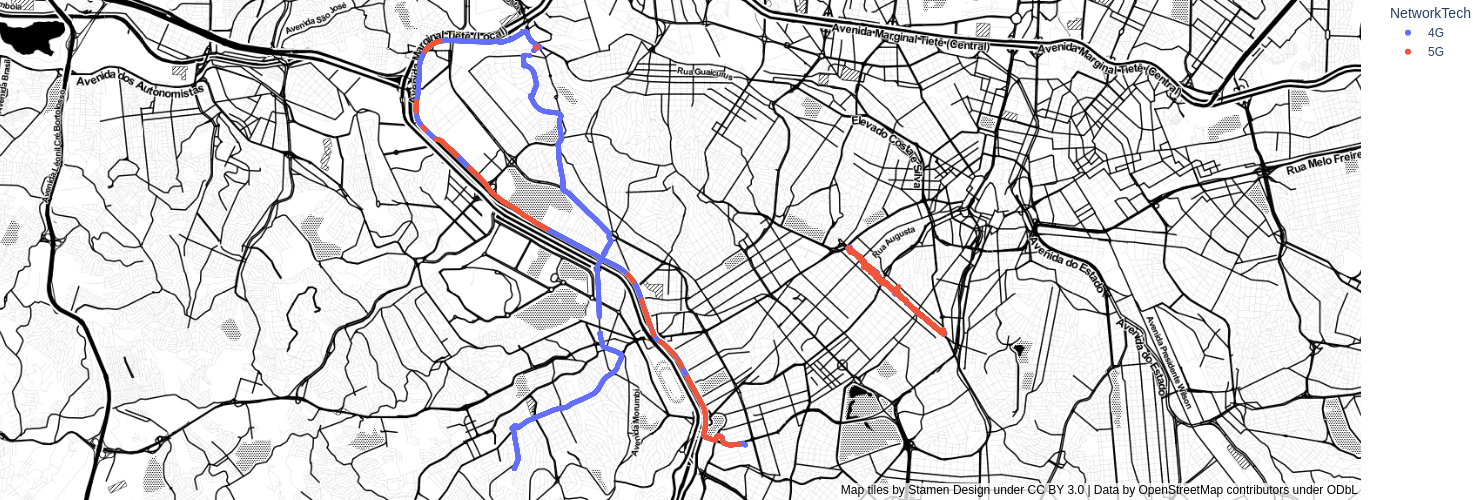

In [12]:
import plotly.express as px

df = gnetDf[['Timestamp', 'Longitude', 'Latitude', 'NetworkTech']].dropna().reset_index()

fig = px.scatter_mapbox(df, lat='Latitude', lon='Longitude', color='NetworkTech',
                        size_max=20, zoom=11.8, width=1000, height=500,
                        center=dict(lon=(df.Longitude.min() + df.Longitude.max()) / 2, lat=(df.Latitude.min() + df.Latitude.max()) / 2))

fig.update_layout(
    mapbox=dict(
        style=
        #'carto-darkmatter'
        #'carto-positron'
        #'open-street-map'
        'stamen-toner'
        #'stamen-watercolor'
        #'white-bg'
        ,
    ),
    margin=dict(l=0, r=0, t=0, b=0),
)

Fazemos alguns gráficos sobre a relação da tecnologia da rede e outros parâmetros (como bitrate de download e upload, e qualidade de sinal)

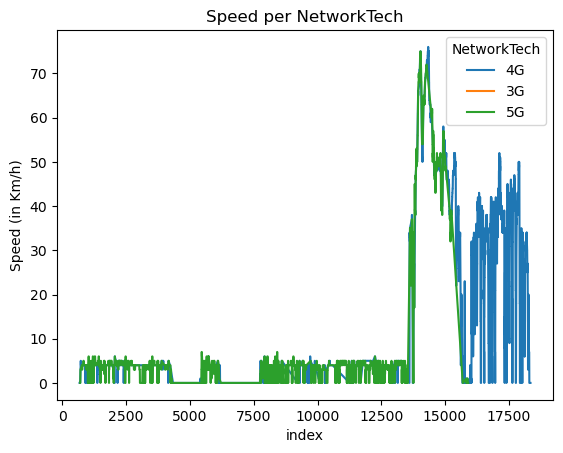

In [13]:
g = sns.lineplot(data=gnetDf.reset_index(), x='index', y='Speed', hue='NetworkTech')
g.set(ylabel='Speed (in Km/h)')
g.set_title('Speed per NetworkTech');

In [14]:
import matplotlib.ticker as tkr  

def sizeof_format(x, pos):
    if x < 0:
        return ''
    for x_unit in ['bytes', 'kB', 'MB', 'GB', 'TB']:
        if x < 1024.:
            return '%3.1f %s' % (x, x_unit)
        x /= 1024.

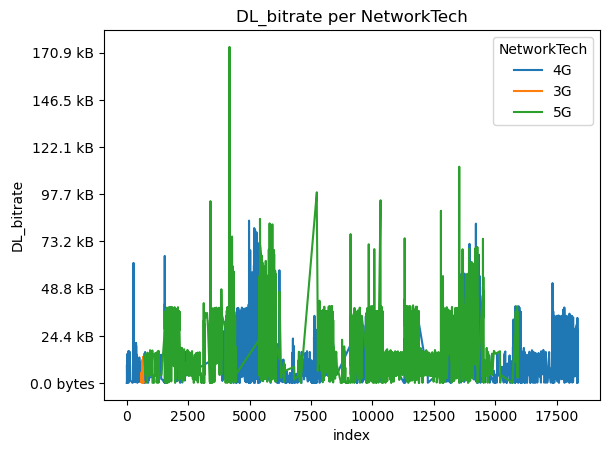

In [15]:
g = sns.lineplot(data=gnetDf[gnetDf.DL_bitrate > 60].reset_index(), x='index', y='DL_bitrate', hue='NetworkTech')
g.yaxis.set_major_formatter(tkr.FuncFormatter(sizeof_format))
g.set_title('DL_bitrate per NetworkTech');

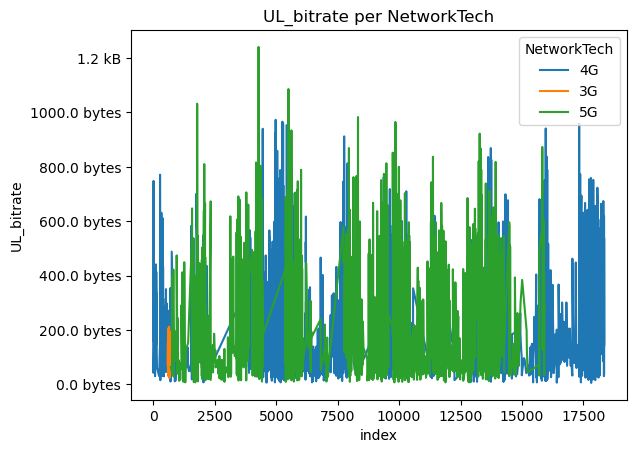

In [16]:
g = sns.lineplot(data=gnetDf[gnetDf.DL_bitrate > 60].reset_index(), x='index', y='UL_bitrate', hue='NetworkTech')
g.yaxis.set_major_formatter(tkr.FuncFormatter(sizeof_format))
g.set_title('UL_bitrate per NetworkTech');

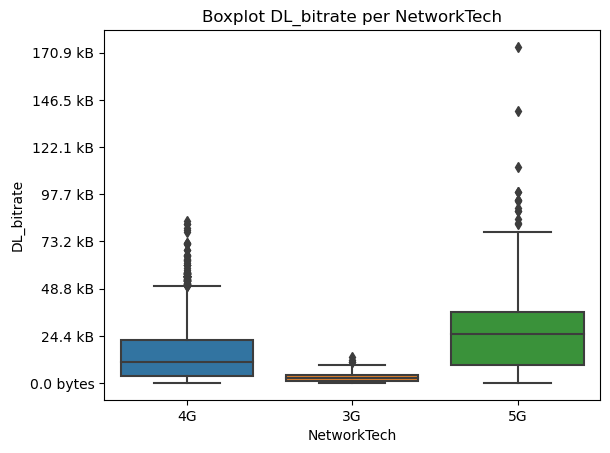

In [17]:
g = sns.boxplot(data=gnetDf[gnetDf.DL_bitrate > 60], x='NetworkTech', y='DL_bitrate')
g.yaxis.set_major_formatter(tkr.FuncFormatter(sizeof_format))
g.set_title('Boxplot DL_bitrate per NetworkTech');

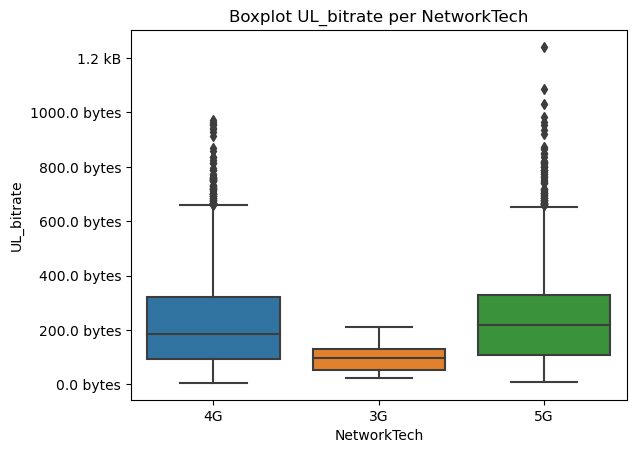

In [18]:
g = sns.boxplot(data=gnetDf[gnetDf.DL_bitrate > 60], x='NetworkTech', y='UL_bitrate')
g.yaxis.set_major_formatter(tkr.FuncFormatter(sizeof_format))
g.set_title('Boxplot UL_bitrate per NetworkTech');

In [19]:
gnetDf.groupby('NetworkTech')[['DL_bitrate', 'UL_bitrate']].describe()

DL_bitrate                                                      
                 count         mean           std  min  25%   50%     75%   
NetworkTech                                                                 
3G                95.0  1640.168421   3001.051563  0.0  3.0  11.0  2212.0  \
4G              8603.0  6243.720911  11734.321345  0.0  3.0   5.0  7364.5   
5G              9595.0  7396.030433  14957.672194  0.0  3.0   4.0  4196.0   

                      UL_bitrate                                          
                  max      count       mean         std  min  25%   50%   
NetworkTech                                                               
3G            13859.0       95.0  51.168421   57.696870  2.0  5.5  23.0  \
4G            86031.0     8603.0  98.485877  153.889928  0.0  5.0   7.0   
5G           178074.0     9595.0  75.583220  139.969647  0.0  5.0   6.0   

                            
               75%     max  
NetworkTech                 
3G            90.0   212.0  
4G           143.0   973.0  
5G            65.0  1241.0

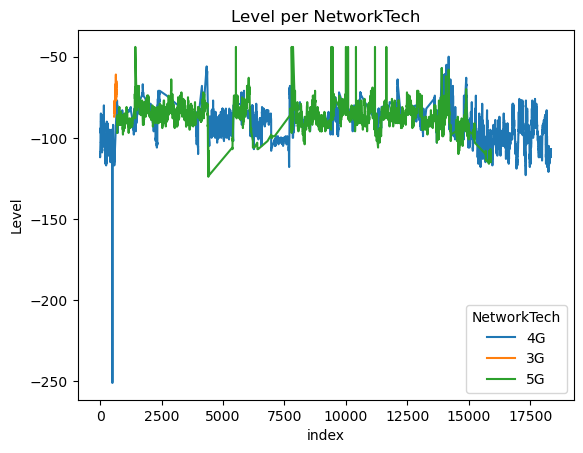

In [20]:
g = sns.lineplot(data=gnetDf.reset_index(), x='index', y='Level', hue='NetworkTech')
g.set_title('Level per NetworkTech');

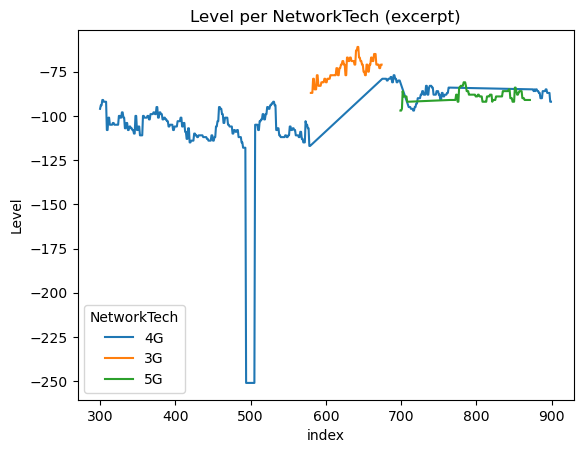

In [21]:
g = sns.lineplot(data=gnetDf.reset_index()[300:900], x='index', y='Level', hue='NetworkTech')
g.set_title('Level per NetworkTech (excerpt)');

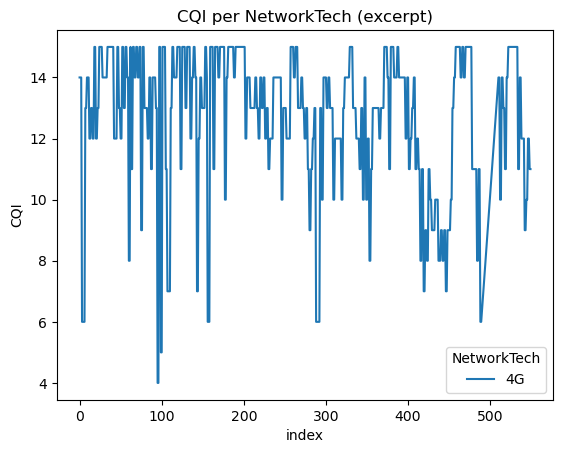

In [22]:
g = sns.lineplot(data=gnetDf.reset_index()[:550], x='index', y='CQI', hue='NetworkTech')
g.set_title('CQI per NetworkTech (excerpt)');

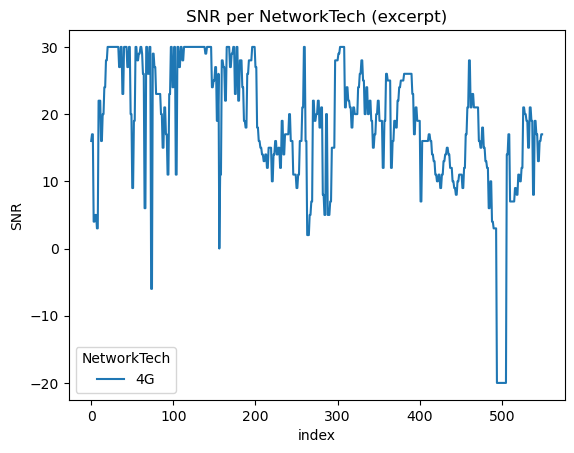

In [23]:
g = sns.lineplot(data=gnetDf.reset_index()[:550], x='index', y='SNR', hue='NetworkTech')
g.set_title('SNR per NetworkTech (excerpt)');